In [370]:
import numpy as np
import plotly.graph_objects as go 
import scipy.constants as cst
import matplotlib.pyplot as plt

In [371]:
class Maillage : 
    #Initialisation de l'objet.
    def __init__(self,X : np.ndarray ,Y : np.ndarray,Z : np.ndarray) :         
        if not((size := X.size) == Y.size == Z.size) : 
            raise ValueError('Les 3 matrices doivent avoir les mêmes dimensions.')
        
        #Les listes sont flatten par convénience.
        X,Y,Z = X.flatten(),Y.flatten(),Z.flatten()
        self.X = X
        self.Y = Y
        self.Z = Z
        self.XYZ = np.array([X,Y,Z])
        self.nb_points = size
    
    #Définition de l'addition de "Maillage1 + Maillage2".
    def __add__(self,maillage : "Maillage") -> "Maillage" : 
        X,Y,Z = np.concatenate((self.X,maillage.X)),np.concatenate((self.Y,maillage.Y)),np.concatenate((self.Z,maillage.Z))
        return  Maillage(X,Y,Z) 
    
    #Définition de la multiplication scalaire ie "scalaire * Maillage".
    def __rmul__(self,scalaire) :
        return Maillage(scalaire*self.X,scalaire*self.Y,scalaire*self.Z) 
    
    #Définition de l'expression Maillage[indice].
    def __getitem__(self,index : int) -> "Maillage" : 
        return self.X[index],self.Y[index],self.Z[index]
    
    #Définition de l'égalité entre deux maillages ie "Maillage1 == Maillage2".
    def __eq__(self, maillage : "Maillage"):
        return np.array_equal(self.X, maillage.X) and \
               np.array_equal(self.Y, maillage.Y) and \
               np.array_equal(self.Z, maillage.Z)


    def translate(self, dl : tuple[float]) -> "Maillage":
        if len(dl) != 3:
            raise ValueError('Trop ou pas assez de translations ont été données.')

        return Maillage(self.X + dl[0], self.Y + dl[1], self.Z + dl[2])
    
    def norm(self) : 
        return np.sqrt(self.X**2 + self.Y**2 + self.Z**2)
    
    def rotate(self, axes : list[str], angles : list[float]) -> "Maillage" : 
        if len(axes) != len(angles):
            raise ValueError("Trop ou pas assez d'angles et/ou axes ont été donnés.")

        Rx = lambda angle : np.array([[1,0,0],[0,np.cos(angle),-np.sin(angle)],[0,np.sin(angle),np.cos(angle)]])
        Ry = lambda angle : np.array([[np.cos(angle),0,np.sin(angle)],[0,1,0],[-np.sin(angle),0,np.cos(angle)]])
        Rz = lambda angle : np.array([[np.cos(angle),-np.sin(angle),0],[np.sin(angle),np.cos(angle),0],[0,0,1]])
        product = ''
    
        for axe,angle in zip(axes,angles) : 
            product = f'R{axe.strip().lower()}({angle}) @' + product
        
        return Maillage(*eval(f'{product} self.XYZ')) 

In [372]:
def creer_maillage_cartesien(x_min : float, x_max : float, y_min : float, y_max : float, z_min : float, z_max : float, pas_du_maillage : float) -> Maillage:
    """
    Entrées:

        - x_min : la valeur minimale en x du maillage (Exemple : x_min = -2.5). Le signe est quelconque et la valeur doit être différente de x_max.
        - y_min : la valeur minimale en y du maillage (Exemple : y_min = -2.5). Le signe est quelconque et la valeur doit être différente de y_max.
        - z_min : la valeur minimale en z du maillage (Exemple : z_min = -2.5). Le signe est quelconque et la valeur doit être différente de z_max.

        - x_max : la valeur maximale en x du maillage (Exemple : x_max = 2.5). Le signe est quelconque et la valeur doit être différente de x_min.
        - y_max : la valeur maximale en y du maillage (Exemple : y_max = 2.5). Le signe est quelconque et la valeur doit être différente de y_min.
        - z_max : la valeur maximale en z du maillage (Exemple : z_max = 2.5). Le signe est quelconque et la valeur doit être différente de z_min.

        - pas_du_maillage : 
            
            * Distance séparant 2 points (non diagonnaux) du maillage. 
            
            * Il est de préférence un diviseur de (x_max - x_min) et de (y_max - y_min) et (z_max - z_min). 
            
            * Éviter un pas égal à 0.3 ou quelconque multiple de 0.3 ainsi que les nombres premiers par exemple. 
            
            * Sa valeur ne doit pas être plus élevée que la moitié de la plus petite distance coordonnée_max - coordonnée_min des 3 axes.
        
    Sorties:
    
        - [X,Y,Z] : C'est une liste qui contient 3 listes de NP.ARRAYS 2D. 
            
            * len(X) = len(Y) = len(Z) = nb_points_entre_y_min_y_max.
            
            * X[0] ou Y[0] ou Z[0] représente le plan (xOz) pour y = y_min, X[1] ou Y[1] ou Z[1] pour y = y_min + pas_du_maillage et ainsi 
                de suite jusqu'à y = y_max. 
            
            * De plus, pour chaque NP.ARRAY de X, Y ou Z, X[y_fixé][:,0], Y[y_fixé][:,0], Z[y_fixé][:,0] représente les droites parallèles 
                à l'axe (Ox) pour y = y_fixé et z = z_min. De même, X[y_fixé][:,1], Y[y_fixé][:,1], Z[y_fixé][:,1] représente les droites 
                parallèles à l'axe (Ox) pour y = y_fixé et z = z_min + pas_du_maillage. 
            
            * On a également X[y_fixé][0,:], Y[y_fixé][0,:], Z[y_fixé][0,:] représente les droites parallèles à l'axe (Oz) pour y = y_fixé et 
                x = x_min. De même, X[y_fixé][1,:], Y[y_fixé][1,:], Z[y_fixé][1,:] représente les droites parallèles à l'axe (Oz) pour y = y_fixé 
                et x = x_min + pas_du_maillage.
            
    Explication:
    
        La fonction creer_maillage_cartesien() crée une maillage de l'espace pour des limites et un pas donnés.
    """
    
    #Vérification de la cohérence des données.
    for min, max in zip([x_min,y_min,z_min],[x_max,y_max,z_max]):
        est_un_plan = False
        est_une_droite = False
        
        if min == max: #Sinon le maillage est soit: un plan, une droite ou un point ce qui ne nous intéresse pas ici.
            if est_un_plan:
                if est_une_droite:
                    raise ValueError("Le maillage est un point.")
                est_une_droite = True
            est_un_plan = True    
    
        if min > max:
            min, max = max, min #Nécessaire pour avoir des np.linspace(min, max, nb_points) cohérents.
        
        if not est_un_plan:   
            if pas_du_maillage > abs(max-min)/2:
                raise ValueError("pas_du_maillage est trop grand.") #Le cas écheant, le maillage ne serait pas bien défini.

    #Création du maillage.
    longueur_maillage_x = abs(x_max - x_min)
    longueur_maillage_y = abs(y_max - y_min)
    longueur_maillage_z = abs(z_max - z_min)
    
    try:
        nb_points_entre_x_min_x_max = int((longueur_maillage_x) / (pas_du_maillage)) + 1
    except:
        raise ZeroDivisionError
    try:
        nb_points_entre_y_min_y_max = int((longueur_maillage_y) / (pas_du_maillage)) + 1
    except:
        raise ZeroDivisionError
    try:
        nb_points_entre_z_min_z_max = int((longueur_maillage_z) / (pas_du_maillage)) + 1
    except:
        raise ZeroDivisionError
    
    axe_x = np.linspace(x_min, x_max, nb_points_entre_x_min_x_max)
    axe_y = np.linspace(y_min, y_max, nb_points_entre_y_min_y_max)
    axe_z = np.linspace(z_min, z_max, nb_points_entre_z_min_z_max)
    
    X,Y,Z = np.meshgrid(axe_x,axe_y,axe_z)
    
    #Permet de gérer les cas où pas_du_maillage engendre des points dont les coordonnées ont des décimales infinies comme 0.3.
    X = np.round(X, 1) 
    Y = np.round(Y, 1)
    Z = np.round(Z, 1)

    return Maillage(X,Y,Z)

cote = 2 #N'est pas une variable globale.
pas_du_maillage = 0.1 #N'est pas une variable globale.
test = creer_maillage_cartesien(-cote,cote,-cote,cote,-cote,cote,pas_du_maillage)  

In [373]:
def spherique_to_cartesien(r : float, theta : float, phi : float) -> tuple:
    return r * np.cos(phi) * np.sin(theta), r * np.sin(phi) * np.sin(theta), r * np.cos(theta)

In [374]:
def cylindrique_to_cartesien(r : float, theta : float, z : float) -> tuple:
    return r*np.cos(theta), r*np.sin(theta), z

In [375]:
def ajouter_trace_maillage(fig: go.Figure, maillage : Maillage):
    
    fig.add_traces(go.Scatter3d(
        x = maillage.X,
        y = maillage.Y,
        z = maillage.Z,
        mode="markers",
        marker=dict(size=1)))
    

In [376]:
def afficher_plotly(maillages : list[Maillage]):
    fig = go.Figure()
    
    for maillage in maillages:
        ajouter_trace_maillage(fig, maillage)
    
    fig.show()

In [377]:
def afficher_matplotlib(maillage : Maillage) :

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    sc = ax.scatter(maillage.X, maillage.Y, maillage.Z, marker='o', s = 0.5)

    ax.set_xlabel("X")
    ax.set_ylabel("Y")

    plt.show()

In [378]:
def creer_plan(x_min : float, x_max : float, y_min : float, y_max : float, z : "function", pas_x : float, pas_y : float) -> Maillage : 
    densite_x = int(1/pas_x)
    densite_y = int(1/pas_y)
    
    x = np.linspace(x_min,x_max, densite_x*int(x_max - x_min)+1)
    y = np.linspace(y_min,y_max, densite_y*int(y_max - y_min)+1)
    X,Y = np.meshgrid(x,y)
    Z = np.full_like(X, z(X, Y))
    
    return Maillage(X,Y,Z)

In [379]:
def pave(x_min : float, x_max : float, y_min : float, y_max : float, z_min : float, z_max : float, pas_du_maillage : float) -> Maillage : 
    M = Maillage(*np.empty((3,0)))
    densite_x = int(1/pas_du_maillage)
    Z = np.linspace(z_min,z_max, densite_x*int(z_max - z_min)+1)
    
    for z in Z : 
        M += creer_plan(x_min,x_max,y_min,y_max,lambda x,y : z, pas_du_maillage,pas_du_maillage)
    
    return M

In [380]:
def cercle(rayon : float, cote : float, pas : float) -> Maillage:
    
    if rayon == 0:
       return Maillage(np.array([0.]), np.array([0.]), np.array([cote]))

    pi = np.pi
    angle = 2*pi * rayon
    nb_points =  int(angle / pas)  # arrondi et créé des trucs bizarres.
    
    theta = np.linspace(0, 2 * pi, nb_points, endpoint=False)
    r = np.full(nb_points, rayon, float)
    z = np.full(nb_points, cote, float)
    
    x, y, z_cart = cylindrique_to_cartesien(r, theta, z)
    return Maillage(x, y, z_cart)

In [381]:
def disque(rayon : float, cote : float, pas) -> Maillage:
    nb_points = int(rayon/pas)
    disque = Maillage(*np.empty((3,0)))

    for r in np.linspace(0,rayon, nb_points):
        disque += cercle(r,cote,pas)
    
    return disque

In [382]:
def sphere(rayon : float, pas : float) -> Maillage: 
    pi = np.pi
    
    

In [383]:
def calculer_charge(valeur_totale : float, nb_points : int):
    return valeur_totale/nb_points

print(calculer_charge(10,100))

0.1


In [384]:
def potentiel(coordonnees_charge : np.ndarray, point : np.ndarray, valeur_charge : float):
    return valeur_charge/(4 * np.pi * cst.epsilon_0 * np.sqrt((coordonnees_charge[0] - point[0])**2 + (coordonnees_charge[1] - point[1])**2 + (coordonnees_charge[2] - point[2])**2))

In [385]:
potentiel(np.array([0,0,0]), np.array([0,0,1]), 1e-9)

np.float64(8.9875517861708)

In [386]:
#Il faut accepter que le champ soit aberrant sur la surface à cause de la discrétisation -> limite de la modélisation.

k= 1/(4*np.pi*cst.epsilon_0)
test = disque(2, 0 , 0.5)

point = np.array([0,0,0.1])

q = calculer_charge(1e-9, test.nb_points)
u = -1*test.translate(-point)

norme = u.norm()
vect = np.sum(k*q*u.XYZ/norme**3,axis=1)

print(vect)

fig = go.Figure()

fig.add_traces(go.Scatter3d(
    x = test.X,
    y = test.Y,
    z = test.Z,
    mode="markers",
    marker=dict(size=1))
)

fig.add_traces(go.Scatter3d(
    x = [point[0],point[0] + vect[0]],
    y = [point[1],point[1] + vect[1]],
    z = [point[2],point[2] + vect[2]],
    mode="lines+markers",
    marker=dict(size=3))
)

fig.add_traces(go.Scatter3d(
    x = [0, point[0]],
    y = [0, point[1]], 
    z = [0, point[2]],
    mode="lines+markers",
    marker=dict(size=3)))


[-4.16333634e-17 -2.94902991e-16  1.86207780e+01]


In [387]:
def calcule_champ(distribution : Maillage, maillage : Maillage, charge : float) :
    k= 1/(4*np.pi*cst.epsilon_0)
    V = []
    for i in range(maillage.XYZ.shape[1]) : 
        point = maillage.XYZ[:,i]
        
        u = (-1*distribution).translate(point)
        norme = u.norm()
        norme[abs(norme) < 0.01] = 1e30
        resultat = k*charge*u.XYZ/norme**3
        vect = np.sum(resultat,axis=1)
        V.append(vect)
    return V



In [388]:
def calcule_champ(distribution : Maillage, maillage : Maillage, charge : float):
    k = 1 / (4 * np.pi * cst.epsilon_0)
    V = []
    for i in range(maillage.XYZ.shape[1]):
        point = maillage.XYZ[:, i]
        
        u = (-1 * distribution).translate(point)
        norme = u.norm()
        masque = norme >= 0.01  # Ne garde que les points à distance raisonnable
        if np.any(masque):
            u_XYZ_filtré = u.XYZ[:, masque]
            norme_filtré = norme[masque]
            resultat = k * charge * u_XYZ_filtré / (norme_filtré)**3
            vect = np.sum(resultat, axis=1)
        else:
            vect = np.zeros(3)
            
        V.append(vect)

    return V


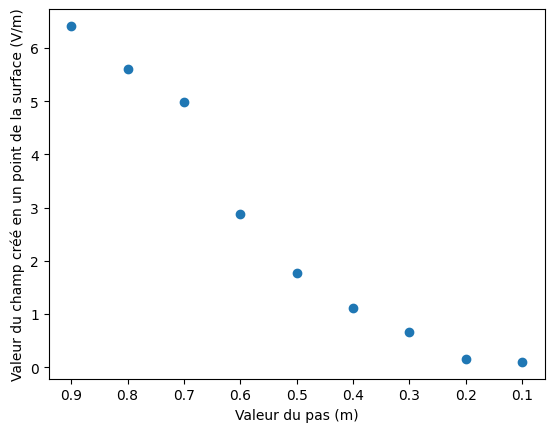

In [389]:
Y = []
X = np.arange(0.1,1,0.1)

for n in X :
    plan = disque(2,0, n)
    q = calculer_charge(1e-10,plan.nb_points)
    k= 1/(4*np.pi*cst.epsilon_0)
    point = np.array([0,0.1,0])
    u = -1*plan.translate(-point)

    norme = u.norm()
    vect = np.sum(k*q*u.XYZ/norme**3,axis=1)
    Y.append(vect[1])

plt.scatter(X,Y)
plt.gca().invert_xaxis() 
plt.xlabel("Valeur du pas (m)")
plt.ylabel("Valeur du champ créé en un point de la surface (V/m)")
plt.show()

In [390]:
#distribution = disque(2,0, 0.01)
distribution = creer_plan(-2,2,-2,2,lambda x,y : 0,1,1)
#maillage = plan(2,1, 0.5)
#maillage = Maillage(*np.array([0,0,0.00001]))
maillage = creer_plan(-2,2,-2,2,lambda x,y : 1,1,1)
q = calculer_charge(1e-9,distribution.nb_points)


vect = calcule_champ(distribution,maillage,q)

fig = go.Figure()
fig.add_traces(go.Scatter3d(x=distribution.X,y=distribution.Y,z=distribution.Z,mode="markers", marker=dict(size=1)))

for i in range(maillage.XYZ.shape[1]) : 
    fig.add_traces(go.Scatter3d(x= [maillage.XYZ[0,i],maillage.XYZ[0,i] + vect[i][0]],
                                y= [maillage.XYZ[1,i],maillage.XYZ[1,i] + vect[i][1]],
                                z= [maillage.XYZ[2,i],maillage.XYZ[2,i] + vect[i][2]],
                                mode="lines+markers", marker=dict(size=3, color="red"), showlegend=False))
fig.show()
                                
print(vect[0][2])

0.9044169527519568


3.469799727465856 %, 59 points.


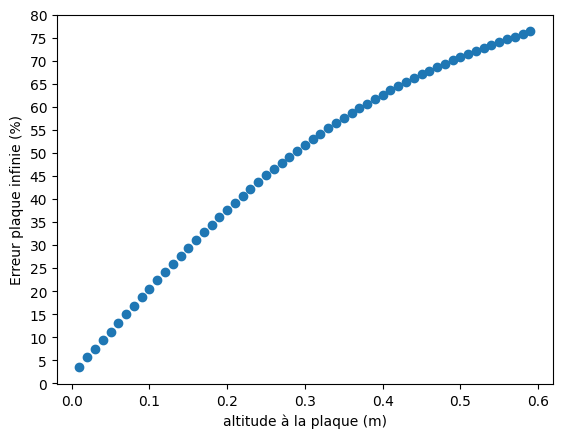

In [398]:
Y = []
X = np.arange(0.01,0.6,0.01)
rayon = 0.5
dimension = 0.1
charge = 1e-9
valeur_theorique = charge / (2*cst.epsilon_0*np.pi*rayon**2)

#Les limites du modèle (discrétisation notamment) se prennent le dessus dès lors que l'altitude est inférieure au pas de discrétisation du maillage, il est donc recommandé de se placer à une altitude supérieure au pas.

for altitude in X:
    #distribution = creer_maillage_cartesien(-dimension,dimension,-dimension,dimension,0,0, 0.001)
    distribution = disque(rayon, 0, 0.005)
    maillage = Maillage(*np.array([0,0,altitude]))
    q = calculer_charge(charge,distribution.nb_points)
    vect = calcule_champ(distribution,maillage,q)
    Y.append(abs(vect[0][2] - valeur_theorique)/valeur_theorique*100)
    
print(f'{Y[0]} %, {len(Y)} points.')
plt.xlabel("altitude à la plaque (m)")
plt.ylabel("Erreur plaque infinie (%)")
plt.yticks(np.arange(0, 101, 5))
plt.scatter(X,Y)
plt.show()

In [392]:
commentaire = {0.001 : 2.4831374361190615}